# Машинное обучение, ФКН ВШЭ

# Практическое задание 12. Несбалансированные задачи

## Общая информация
Дата выдачи: 01.05.2022

Мягкий дедлайн: 11.05.2022 23:59 MSK

Жёсткий дедлайн: 16.05.2022 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [2]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [4]:
df['Class'].mean()

0.001727485630620034

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [5]:
df['day'] = df['Time'] / 60 / 60 // 24
df['hour'] = (df['Time'] / 60 / 60 % 24).round()

In [6]:
df = df.drop('Time', axis=1)

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

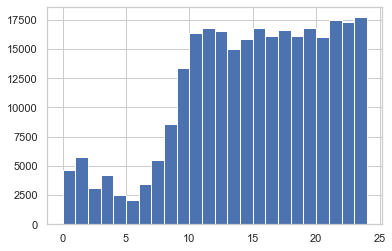

In [7]:
# 1
df['hour'].hist(bins=24);

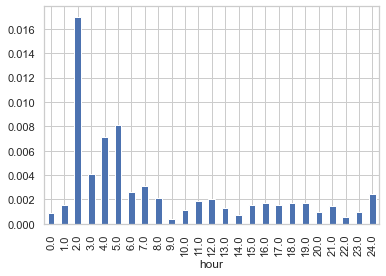

In [8]:
# 2
df.groupby('hour')['Class'].mean().plot.bar();

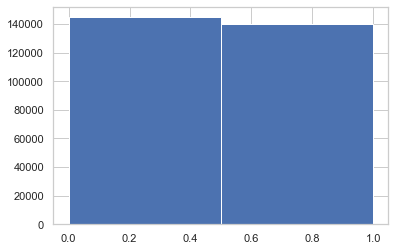

In [9]:
# day 1
df['day'].hist(bins=2);

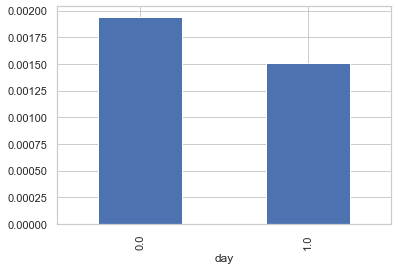

In [10]:
# day 2
df.groupby('day')['Class'].mean().plot.bar();

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

Выбрал порог 0.2

In [11]:
abs(df.corr()['Class']) > 0.2

V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10        True
V11       False
V12        True
V13       False
V14        True
V15       False
V16       False
V17        True
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class      True
day       False
hour      False
Name: Class, dtype: bool

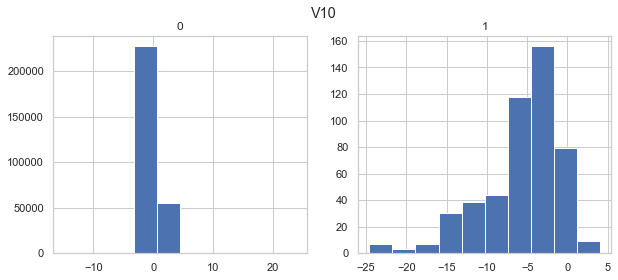

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(df[df['Class'] == 0]['V10'])
ax[0].set_title('0')
ax[1].hist(df[df['Class'] == 1]['V10'])
ax[1].set_title('1')
fig.suptitle('V10');

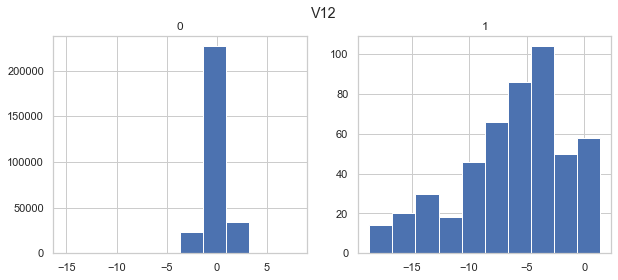

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(df[df['Class'] == 0]['V12'])
ax[0].set_title('0')
ax[1].hist(df[df['Class'] == 1]['V12'])
ax[1].set_title('1')
fig.suptitle('V12');

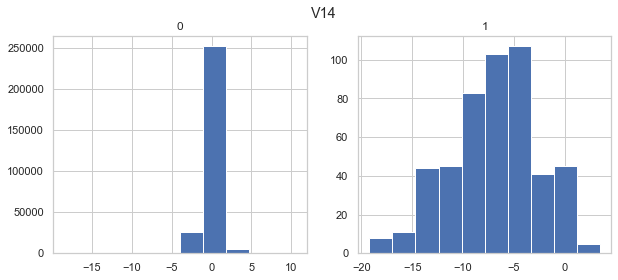

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(df[df['Class'] == 0]['V14'])
ax[0].set_title('0')
ax[1].hist(df[df['Class'] == 1]['V14'])
ax[1].set_title('1')
fig.suptitle('V14');

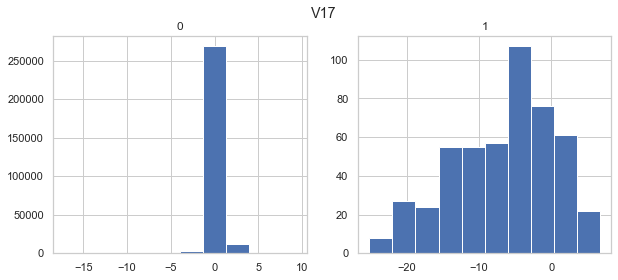

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(df[df['Class'] == 0]['V17'])
ax[0].set_title('0')
ax[1].hist(df[df['Class'] == 1]['V17'])
ax[1].set_title('1')
fig.suptitle('V17');

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [16]:
size = df.shape[0]
X_train = df.iloc[0: int(size * 0.8)]
X_val = df.iloc[int(size * 0.8): int(size * 0.85)]
X_test = df.iloc[int(size * 0.85): size + 1]

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [17]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [18]:
from sklearn.metrics import cohen_kappa_score

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [19]:
from sklearn.metrics import matthews_corrcoef

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [20]:
naive_pred = np.zeros(X_train.shape[0])

In [21]:
average_precision_score(X_train['Class'], naive_pred)

0.001830191577607584

In [22]:
cohen_kappa_score(X_train['Class'], naive_pred)

0.0

In [23]:
matthews_corrcoef(X_train['Class'], naive_pred)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [24]:
import sys
sys.path.append('/Users/leon/Documents/Всячина/MyPython/PC/venv/lib/python3.8/site-packages/')

In [25]:
from catboost import CatBoostClassifier

In [26]:
cat = CatBoostClassifier()

In [27]:
cat.fit(X_train.drop('Class', axis=1), X_train['Class'])

Learning rate set to 0.104628
0:	learn: 0.3623370	total: 84.5ms	remaining: 1m 24s
1:	learn: 0.1885549	total: 103ms	remaining: 51.6s
2:	learn: 0.0989066	total: 122ms	remaining: 40.6s
3:	learn: 0.0549181	total: 141ms	remaining: 35.1s
4:	learn: 0.0332784	total: 160ms	remaining: 31.9s
5:	learn: 0.0210836	total: 180ms	remaining: 29.8s
6:	learn: 0.0141629	total: 207ms	remaining: 29.3s
7:	learn: 0.0098962	total: 229ms	remaining: 28.4s
8:	learn: 0.0074364	total: 243ms	remaining: 26.8s
9:	learn: 0.0060318	total: 258ms	remaining: 25.6s
10:	learn: 0.0051046	total: 274ms	remaining: 24.6s
11:	learn: 0.0043935	total: 289ms	remaining: 23.8s
12:	learn: 0.0039370	total: 304ms	remaining: 23.1s
13:	learn: 0.0036136	total: 320ms	remaining: 22.5s
14:	learn: 0.0033369	total: 334ms	remaining: 21.9s
15:	learn: 0.0031616	total: 350ms	remaining: 21.5s
16:	learn: 0.0030382	total: 364ms	remaining: 21s
17:	learn: 0.0029473	total: 379ms	remaining: 20.7s
18:	learn: 0.0028496	total: 399ms	remaining: 20.6s
19:	learn: 

162:	learn: 0.0012630	total: 2.85s	remaining: 14.6s
163:	learn: 0.0012600	total: 2.88s	remaining: 14.7s
164:	learn: 0.0012582	total: 2.9s	remaining: 14.7s
165:	learn: 0.0012562	total: 2.92s	remaining: 14.7s
166:	learn: 0.0012532	total: 2.94s	remaining: 14.6s
167:	learn: 0.0012523	total: 2.95s	remaining: 14.6s
168:	learn: 0.0012509	total: 2.97s	remaining: 14.6s
169:	learn: 0.0012453	total: 2.98s	remaining: 14.6s
170:	learn: 0.0012400	total: 3s	remaining: 14.6s
171:	learn: 0.0012374	total: 3.02s	remaining: 14.5s
172:	learn: 0.0012354	total: 3.03s	remaining: 14.5s
173:	learn: 0.0012311	total: 3.06s	remaining: 14.5s
174:	learn: 0.0012261	total: 3.07s	remaining: 14.5s
175:	learn: 0.0012152	total: 3.1s	remaining: 14.5s
176:	learn: 0.0012137	total: 3.12s	remaining: 14.5s
177:	learn: 0.0012088	total: 3.13s	remaining: 14.5s
178:	learn: 0.0012074	total: 3.15s	remaining: 14.4s
179:	learn: 0.0012042	total: 3.17s	remaining: 14.4s
180:	learn: 0.0011988	total: 3.18s	remaining: 14.4s
181:	learn: 0.001

329:	learn: 0.0007706	total: 5.53s	remaining: 11.2s
330:	learn: 0.0007704	total: 5.55s	remaining: 11.2s
331:	learn: 0.0007681	total: 5.56s	remaining: 11.2s
332:	learn: 0.0007651	total: 5.58s	remaining: 11.2s
333:	learn: 0.0007616	total: 5.59s	remaining: 11.2s
334:	learn: 0.0007606	total: 5.61s	remaining: 11.1s
335:	learn: 0.0007576	total: 5.62s	remaining: 11.1s
336:	learn: 0.0007564	total: 5.64s	remaining: 11.1s
337:	learn: 0.0007555	total: 5.66s	remaining: 11.1s
338:	learn: 0.0007534	total: 5.67s	remaining: 11.1s
339:	learn: 0.0007492	total: 5.69s	remaining: 11s
340:	learn: 0.0007479	total: 5.7s	remaining: 11s
341:	learn: 0.0007449	total: 5.72s	remaining: 11s
342:	learn: 0.0007425	total: 5.74s	remaining: 11s
343:	learn: 0.0007408	total: 5.75s	remaining: 11s
344:	learn: 0.0007401	total: 5.77s	remaining: 11s
345:	learn: 0.0007346	total: 5.79s	remaining: 10.9s
346:	learn: 0.0007319	total: 5.8s	remaining: 10.9s
347:	learn: 0.0007311	total: 5.82s	remaining: 10.9s
348:	learn: 0.0007246	tota

496:	learn: 0.0004273	total: 8.25s	remaining: 8.35s
497:	learn: 0.0004260	total: 8.27s	remaining: 8.33s
498:	learn: 0.0004221	total: 8.29s	remaining: 8.32s
499:	learn: 0.0004213	total: 8.3s	remaining: 8.3s
500:	learn: 0.0004203	total: 8.32s	remaining: 8.29s
501:	learn: 0.0004184	total: 8.34s	remaining: 8.27s
502:	learn: 0.0004158	total: 8.36s	remaining: 8.26s
503:	learn: 0.0004149	total: 8.38s	remaining: 8.24s
504:	learn: 0.0004137	total: 8.39s	remaining: 8.23s
505:	learn: 0.0004126	total: 8.41s	remaining: 8.21s
506:	learn: 0.0004089	total: 8.43s	remaining: 8.19s
507:	learn: 0.0004082	total: 8.44s	remaining: 8.18s
508:	learn: 0.0004065	total: 8.46s	remaining: 8.17s
509:	learn: 0.0004043	total: 8.48s	remaining: 8.15s
510:	learn: 0.0004034	total: 8.5s	remaining: 8.13s
511:	learn: 0.0004017	total: 8.52s	remaining: 8.12s
512:	learn: 0.0004002	total: 8.54s	remaining: 8.1s
513:	learn: 0.0003984	total: 8.55s	remaining: 8.09s
514:	learn: 0.0003960	total: 8.57s	remaining: 8.07s
515:	learn: 0.00

656:	learn: 0.0002308	total: 11.2s	remaining: 5.86s
657:	learn: 0.0002270	total: 11.2s	remaining: 5.84s
658:	learn: 0.0002256	total: 11.3s	remaining: 5.82s
659:	learn: 0.0002243	total: 11.3s	remaining: 5.81s
660:	learn: 0.0002220	total: 11.3s	remaining: 5.79s
661:	learn: 0.0002208	total: 11.3s	remaining: 5.77s
662:	learn: 0.0002205	total: 11.3s	remaining: 5.75s
663:	learn: 0.0002192	total: 11.3s	remaining: 5.74s
664:	learn: 0.0002189	total: 11.4s	remaining: 5.72s
665:	learn: 0.0002175	total: 11.4s	remaining: 5.7s
666:	learn: 0.0002168	total: 11.4s	remaining: 5.69s
667:	learn: 0.0002164	total: 11.4s	remaining: 5.67s
668:	learn: 0.0002149	total: 11.4s	remaining: 5.65s
669:	learn: 0.0002133	total: 11.4s	remaining: 5.64s
670:	learn: 0.0002121	total: 11.5s	remaining: 5.62s
671:	learn: 0.0002116	total: 11.5s	remaining: 5.6s
672:	learn: 0.0002111	total: 11.5s	remaining: 5.59s
673:	learn: 0.0002106	total: 11.5s	remaining: 5.57s
674:	learn: 0.0002094	total: 11.5s	remaining: 5.55s
675:	learn: 0.

827:	learn: 0.0001422	total: 14.1s	remaining: 2.94s
828:	learn: 0.0001420	total: 14.2s	remaining: 2.92s
829:	learn: 0.0001420	total: 14.2s	remaining: 2.9s
830:	learn: 0.0001419	total: 14.2s	remaining: 2.89s
831:	learn: 0.0001414	total: 14.2s	remaining: 2.87s
832:	learn: 0.0001413	total: 14.2s	remaining: 2.85s
833:	learn: 0.0001413	total: 14.2s	remaining: 2.84s
834:	learn: 0.0001411	total: 14.3s	remaining: 2.82s
835:	learn: 0.0001408	total: 14.3s	remaining: 2.8s
836:	learn: 0.0001408	total: 14.3s	remaining: 2.78s
837:	learn: 0.0001404	total: 14.3s	remaining: 2.77s
838:	learn: 0.0001403	total: 14.3s	remaining: 2.75s
839:	learn: 0.0001399	total: 14.3s	remaining: 2.73s
840:	learn: 0.0001397	total: 14.4s	remaining: 2.72s
841:	learn: 0.0001397	total: 14.4s	remaining: 2.7s
842:	learn: 0.0001389	total: 14.4s	remaining: 2.68s
843:	learn: 0.0001382	total: 14.4s	remaining: 2.67s
844:	learn: 0.0001380	total: 14.4s	remaining: 2.65s
845:	learn: 0.0001377	total: 14.5s	remaining: 2.63s
846:	learn: 0.0

988:	learn: 0.0000994	total: 17.3s	remaining: 192ms
989:	learn: 0.0000991	total: 17.3s	remaining: 175ms
990:	learn: 0.0000991	total: 17.3s	remaining: 157ms
991:	learn: 0.0000991	total: 17.3s	remaining: 140ms
992:	learn: 0.0000989	total: 17.3s	remaining: 122ms
993:	learn: 0.0000985	total: 17.4s	remaining: 105ms
994:	learn: 0.0000983	total: 17.4s	remaining: 87.4ms
995:	learn: 0.0000980	total: 17.4s	remaining: 70.1ms
996:	learn: 0.0000980	total: 17.5s	remaining: 52.6ms
997:	learn: 0.0000969	total: 17.5s	remaining: 35.1ms
998:	learn: 0.0000967	total: 17.5s	remaining: 17.5ms
999:	learn: 0.0000964	total: 17.5s	remaining: 0us


In [28]:
print(average_precision_score(X_test['Class'], cat.predict(X_test.drop('Class', axis=1))))
print(cohen_kappa_score(X_test['Class'], cat.predict(X_test.drop('Class', axis=1))))
print(matthews_corrcoef(X_test['Class'], cat.predict(X_test.drop('Class', axis=1))))

0.620337192700686
0.7775491352835752
0.7871508575994483


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [29]:
scale = (X_train.shape[0] - X_train['Class'].sum()) / X_train['Class'].sum()
cat1 = CatBoostClassifier(scale_pos_weight=scale)

In [78]:
cat1.fit(X_train.drop('Class', axis=1), X_train['Class'])

Learning rate set to 0.104628
0:	learn: 0.4845078	total: 31.6ms	remaining: 31.6s
1:	learn: 0.3728031	total: 54.5ms	remaining: 27.2s
2:	learn: 0.2922179	total: 76.1ms	remaining: 25.3s
3:	learn: 0.2407370	total: 94.8ms	remaining: 23.6s
4:	learn: 0.1932144	total: 115ms	remaining: 22.9s
5:	learn: 0.1709494	total: 134ms	remaining: 22.2s
6:	learn: 0.1557423	total: 153ms	remaining: 21.6s
7:	learn: 0.1418560	total: 172ms	remaining: 21.3s
8:	learn: 0.1349748	total: 192ms	remaining: 21.1s
9:	learn: 0.1277754	total: 215ms	remaining: 21.3s
10:	learn: 0.1143748	total: 243ms	remaining: 21.9s
11:	learn: 0.1061837	total: 263ms	remaining: 21.7s
12:	learn: 0.1007143	total: 286ms	remaining: 21.7s
13:	learn: 0.0952922	total: 304ms	remaining: 21.4s
14:	learn: 0.0921081	total: 322ms	remaining: 21.2s
15:	learn: 0.0860080	total: 341ms	remaining: 21s
16:	learn: 0.0817215	total: 360ms	remaining: 20.8s
17:	learn: 0.0786674	total: 377ms	remaining: 20.6s
18:	learn: 0.0756656	total: 395ms	remaining: 20.4s
19:	learn

161:	learn: 0.0019228	total: 3.13s	remaining: 16.2s
162:	learn: 0.0018965	total: 3.15s	remaining: 16.2s
163:	learn: 0.0018660	total: 3.17s	remaining: 16.2s
164:	learn: 0.0018350	total: 3.19s	remaining: 16.1s
165:	learn: 0.0018096	total: 3.21s	remaining: 16.1s
166:	learn: 0.0017771	total: 3.22s	remaining: 16.1s
167:	learn: 0.0017468	total: 3.24s	remaining: 16.1s
168:	learn: 0.0017143	total: 3.26s	remaining: 16s
169:	learn: 0.0017016	total: 3.28s	remaining: 16s
170:	learn: 0.0016802	total: 3.3s	remaining: 16s
171:	learn: 0.0016689	total: 3.31s	remaining: 15.9s
172:	learn: 0.0016449	total: 3.33s	remaining: 15.9s
173:	learn: 0.0016248	total: 3.35s	remaining: 15.9s
174:	learn: 0.0016212	total: 3.37s	remaining: 15.9s
175:	learn: 0.0015913	total: 3.38s	remaining: 15.8s
176:	learn: 0.0015649	total: 3.4s	remaining: 15.8s
177:	learn: 0.0015513	total: 3.42s	remaining: 15.8s
178:	learn: 0.0015366	total: 3.44s	remaining: 15.8s
179:	learn: 0.0015219	total: 3.46s	remaining: 15.7s
180:	learn: 0.001502

328:	learn: 0.0014467	total: 5.38s	remaining: 11s
329:	learn: 0.0014467	total: 5.39s	remaining: 10.9s
330:	learn: 0.0014467	total: 5.4s	remaining: 10.9s
331:	learn: 0.0014467	total: 5.42s	remaining: 10.9s
332:	learn: 0.0014467	total: 5.43s	remaining: 10.9s
333:	learn: 0.0014467	total: 5.44s	remaining: 10.8s
334:	learn: 0.0014467	total: 5.45s	remaining: 10.8s
335:	learn: 0.0014467	total: 5.46s	remaining: 10.8s
336:	learn: 0.0014467	total: 5.47s	remaining: 10.8s
337:	learn: 0.0014467	total: 5.49s	remaining: 10.7s
338:	learn: 0.0014467	total: 5.5s	remaining: 10.7s
339:	learn: 0.0014467	total: 5.51s	remaining: 10.7s
340:	learn: 0.0014467	total: 5.52s	remaining: 10.7s
341:	learn: 0.0014467	total: 5.54s	remaining: 10.7s
342:	learn: 0.0014467	total: 5.55s	remaining: 10.6s
343:	learn: 0.0014467	total: 5.56s	remaining: 10.6s
344:	learn: 0.0014467	total: 5.57s	remaining: 10.6s
345:	learn: 0.0014467	total: 5.59s	remaining: 10.6s
346:	learn: 0.0014467	total: 5.6s	remaining: 10.5s
347:	learn: 0.001

487:	learn: 0.0014466	total: 7.44s	remaining: 7.8s
488:	learn: 0.0014466	total: 7.45s	remaining: 7.79s
489:	learn: 0.0014466	total: 7.46s	remaining: 7.77s
490:	learn: 0.0014466	total: 7.48s	remaining: 7.75s
491:	learn: 0.0014466	total: 7.49s	remaining: 7.73s
492:	learn: 0.0014466	total: 7.5s	remaining: 7.72s
493:	learn: 0.0014466	total: 7.52s	remaining: 7.7s
494:	learn: 0.0014466	total: 7.53s	remaining: 7.68s
495:	learn: 0.0014466	total: 7.54s	remaining: 7.66s
496:	learn: 0.0014466	total: 7.55s	remaining: 7.65s
497:	learn: 0.0014465	total: 7.57s	remaining: 7.63s
498:	learn: 0.0014465	total: 7.58s	remaining: 7.61s
499:	learn: 0.0014466	total: 7.59s	remaining: 7.59s
500:	learn: 0.0014465	total: 7.61s	remaining: 7.58s
501:	learn: 0.0014465	total: 7.62s	remaining: 7.56s
502:	learn: 0.0014465	total: 7.63s	remaining: 7.54s
503:	learn: 0.0014465	total: 7.65s	remaining: 7.53s
504:	learn: 0.0014465	total: 7.66s	remaining: 7.51s
505:	learn: 0.0014465	total: 7.68s	remaining: 7.5s
506:	learn: 0.00

648:	learn: 0.0014465	total: 9.71s	remaining: 5.25s
649:	learn: 0.0014465	total: 9.73s	remaining: 5.24s
650:	learn: 0.0014465	total: 9.74s	remaining: 5.22s
651:	learn: 0.0014465	total: 9.76s	remaining: 5.21s
652:	learn: 0.0014465	total: 9.77s	remaining: 5.19s
653:	learn: 0.0014465	total: 9.78s	remaining: 5.17s
654:	learn: 0.0014465	total: 9.8s	remaining: 5.16s
655:	learn: 0.0014465	total: 9.81s	remaining: 5.14s
656:	learn: 0.0014465	total: 9.82s	remaining: 5.13s
657:	learn: 0.0014465	total: 9.84s	remaining: 5.11s
658:	learn: 0.0014465	total: 9.85s	remaining: 5.1s
659:	learn: 0.0014465	total: 9.87s	remaining: 5.08s
660:	learn: 0.0014465	total: 9.88s	remaining: 5.07s
661:	learn: 0.0014465	total: 9.89s	remaining: 5.05s
662:	learn: 0.0014465	total: 9.91s	remaining: 5.04s
663:	learn: 0.0014465	total: 9.93s	remaining: 5.02s
664:	learn: 0.0014465	total: 9.94s	remaining: 5.01s
665:	learn: 0.0014465	total: 9.96s	remaining: 4.99s
666:	learn: 0.0014465	total: 9.97s	remaining: 4.98s
667:	learn: 0.

807:	learn: 0.0014462	total: 12s	remaining: 2.85s
808:	learn: 0.0014461	total: 12s	remaining: 2.83s
809:	learn: 0.0014461	total: 12s	remaining: 2.82s
810:	learn: 0.0014461	total: 12s	remaining: 2.8s
811:	learn: 0.0014461	total: 12s	remaining: 2.79s
812:	learn: 0.0014462	total: 12.1s	remaining: 2.77s
813:	learn: 0.0014462	total: 12.1s	remaining: 2.76s
814:	learn: 0.0014462	total: 12.1s	remaining: 2.74s
815:	learn: 0.0014461	total: 12.1s	remaining: 2.73s
816:	learn: 0.0014461	total: 12.1s	remaining: 2.71s
817:	learn: 0.0014461	total: 12.1s	remaining: 2.7s
818:	learn: 0.0014461	total: 12.1s	remaining: 2.68s
819:	learn: 0.0014461	total: 12.2s	remaining: 2.67s
820:	learn: 0.0014461	total: 12.2s	remaining: 2.65s
821:	learn: 0.0014461	total: 12.2s	remaining: 2.64s
822:	learn: 0.0014461	total: 12.2s	remaining: 2.62s
823:	learn: 0.0014461	total: 12.2s	remaining: 2.61s
824:	learn: 0.0014461	total: 12.2s	remaining: 2.59s
825:	learn: 0.0014461	total: 12.2s	remaining: 2.58s
826:	learn: 0.0014461	to

980:	learn: 0.0014459	total: 14.4s	remaining: 280ms
981:	learn: 0.0014459	total: 14.5s	remaining: 265ms
982:	learn: 0.0014459	total: 14.5s	remaining: 250ms
983:	learn: 0.0014459	total: 14.5s	remaining: 236ms
984:	learn: 0.0014459	total: 14.5s	remaining: 221ms
985:	learn: 0.0014459	total: 14.5s	remaining: 206ms
986:	learn: 0.0014459	total: 14.5s	remaining: 191ms
987:	learn: 0.0014459	total: 14.5s	remaining: 177ms
988:	learn: 0.0014459	total: 14.6s	remaining: 162ms
989:	learn: 0.0014459	total: 14.6s	remaining: 147ms
990:	learn: 0.0014459	total: 14.6s	remaining: 132ms
991:	learn: 0.0014459	total: 14.6s	remaining: 118ms
992:	learn: 0.0014459	total: 14.6s	remaining: 103ms
993:	learn: 0.0014459	total: 14.6s	remaining: 88.3ms
994:	learn: 0.0014459	total: 14.6s	remaining: 73.5ms
995:	learn: 0.0014459	total: 14.7s	remaining: 58.8ms
996:	learn: 0.0014459	total: 14.7s	remaining: 44.1ms
997:	learn: 0.0014459	total: 14.7s	remaining: 29.4ms
998:	learn: 0.0014459	total: 14.7s	remaining: 14.7ms
999:	l

In [86]:
print(average_precision_score(X_test['Class'], cat1.predict(X_test.drop('Class', axis=1))))
print(cohen_kappa_score(X_test['Class'], cat1.predict(X_test.drop('Class', axis=1))))
print(matthews_corrcoef(X_test['Class'], cat1.predict(X_test.drop('Class', axis=1))))

0.5738337046348898
0.7569886386130616
0.7570244040292399


Метрики упали

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [90]:
scale

545.3908872901678

In [97]:
for s in tqdm(np.arange(int(scale * 0.2), int(scale * 2), 100)):
    cat3 = CatBoostClassifier(scale_pos_weight=s, silent=True)
    cat3.fit(X_train.drop('Class', axis=1), X_train['Class'])
    print('Scale:', s)
    print('Train:', average_precision_score(X_train['Class'], cat3.predict(X_train.drop('Class', axis=1))))
    print('Val:', average_precision_score(X_val['Class'], cat3.predict(X_val.drop('Class', axis=1))))

Scale: 109
Train: 0.9630484988452656
Val: 0.6984889811648483
Scale: 209
Train: 0.9308035714285714
Val: 0.747692907157978
Scale: 309
Train: 0.9164835164835164
Val: 0.6827005586117542
Scale: 409
Train: 0.9045553145336226
Val: 0.6406673291291025
Scale: 509
Train: 0.8910256410256411
Val: 0.6827005586117542
Scale: 609
Train: 0.8948497854077253
Val: 0.6406673291291025
Scale: 709
Train: 0.8615702479338843
Val: 0.7046989496824622
Scale: 809
Train: 0.879746835443038
Val: 0.7137196340542701
Scale: 909
Train: 0.8760504201680672
Val: 0.6958628480703468
Scale: 1009
Train: 0.7882797731568998
Val: 0.6443330574101214



In [98]:
print(average_precision_score(X_test['Class'], cat3.predict(X_test.drop('Class', axis=1))))
print(cohen_kappa_score(X_test['Class'], cat3.predict(X_test.drop('Class', axis=1))))
print(matthews_corrcoef(X_test['Class'], cat3.predict(X_test.drop('Class', axis=1))))

0.5738337046348898
0.7569886386130616
0.7570244040292399


**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [99]:
!pip3 install imbalanced-learn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [30]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [102]:
smoke = SMOTE()

In [108]:
# 1:1
X_train_smoked1, y_train_smoked1 = smoke.fit_resample(X_train.drop('Class', axis=1), X_train['Class'])

In [115]:
cat4 = CatBoostClassifier(silent=True)
cat4.fit(X_train_smoked1, y_train_smoked1)

In [116]:
print(average_precision_score(X_test['Class'], cat4.predict(X_test.drop('Class', axis=1))))
print(cohen_kappa_score(X_test['Class'], cat4.predict(X_test.drop('Class', axis=1))))
print(matthews_corrcoef(X_test['Class'], cat4.predict(X_test.drop('Class', axis=1))))

0.5343513686530974
0.7304411314019938
0.7304411314019938


In [117]:
smoke = SMOTE(sampling_strategy=1/2)
# 1:2
X_train_smoked2, y_train_smoked2 = smoke.fit_resample(X_train.drop('Class', axis=1), X_train['Class'])
cat5 = CatBoostClassifier(silent=True)
cat5.fit(X_train_smoked2, y_train_smoked2)

print(average_precision_score(X_test['Class'], cat5.predict(X_test.drop('Class', axis=1))))
print(cohen_kappa_score(X_test['Class'], cat5.predict(X_test.drop('Class', axis=1))))
print(matthews_corrcoef(X_test['Class'], cat5.predict(X_test.drop('Class', axis=1))))

0.5853042928701839
0.7644247691641753
0.7645721113350902


In [118]:
smoke = SMOTE(sampling_strategy=1/10)
# 1:10
X_train_smoked10, y_train_smoked10 = smoke.fit_resample(X_train.drop('Class', axis=1), X_train['Class'])
cat6 = CatBoostClassifier(silent=True)
cat6.fit(X_train_smoked2, y_train_smoked2)

print(average_precision_score(X_test['Class'], cat6.predict(X_test.drop('Class', axis=1))))
print(cohen_kappa_score(X_test['Class'], cat6.predict(X_test.drop('Class', axis=1))))
print(matthews_corrcoef(X_test['Class'], cat6.predict(X_test.drop('Class', axis=1))))

0.5853042928701839
0.7644247691641753
0.7645721113350902


Странно, но бейзлайн работает лучше

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - SMOTE, который игнорирует шум, так как из-за него может сгененрироваться слишком много бесполезных объектов, и игнорируются обычные объекты минорного класса. То есть дублируются только те объекты, которые находятся на границе. Граница определяется количестовм объектов мажорного и минорного классов при использовании knn.

SVM-SMOTE - такая же идея, как у BorderlineSMOTE, но граница определяетяс с помощью SVM.

K-Means-SMOTE - SMOTE, который игнориурет только шум. С помощью k-means определяется кластер с минорными объектами и создаются новые объекты для граничных и обычных объектов минорноого класса.

ADASYN - дублирует те объекты, которые неправильно классифицируются с помощью knn. В то время как SMOTE не различает, трудно классифицировать объект или нет.

Теперь попробуйте сравнить качество всех методов на наших данных.

In [ ]:
#your code here

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [119]:
from imblearn.under_sampling import RandomUnderSampler

In [134]:
X_train['Class'].mean()

0.001830191577607584

In [137]:
pr_auc = []
cohen = []
matt = []
ratios = [0.00184, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5]

In [138]:
for ratio in tqdm(ratios):
    print(ratio)
    rus = RandomUnderSampler(sampling_strategy=ratio)
    X_train_rus, y_train_rus = rus.fit_resample(X_train.drop('Class', axis=1), X_train['Class'])
    cat7 = CatBoostClassifier(silent=True)
    cat7.fit(X_train_rus, y_train_rus)
    
    pr_auc_ = average_precision_score(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    pr_auc.append(pr_auc_)
    cohen_ = cohen_kappa_score(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    cohen.append(cohen_)
    matt_ = matthews_corrcoef(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    matt.append(matt_)
    
    print(pr_auc_)
    print(cohen_)
    print(matt_)
    print('_________')

0.00184


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0.6394277687396348
0.7909907339649391
0.7992051463662754
_________
0.002
0.6776260114586972
0.8170079130596475
0.8227961283244573
_________
0.003
0.6585241840809816
0.8041405264648531
0.8110844637119163
_________
0.004
0.6754004168225988
0.8129917093370508
0.8214346011341345
_________
0.005
0.6461237644147598
0.7997793848131702
0.8034007938264056
_________
0.01
0.6040066297799305
0.7752533972011291
0.7767138345967645
_________
0.05
0.43045135169371335
0.6495165217065191
0.6553845376233088
_________
0.1
0.24331705058940375
0.4422671576673395
0.4921298875555772
_________
0.2
0.228819917870184
0.43235068222484596
0.47712875272941746
_________
0.4
0.10127911319784798
0.21879421694672108
0.31619777809400806
_________
0.5
0.10558524200716493
0.22297037104864748
0.3229648794304099
_________



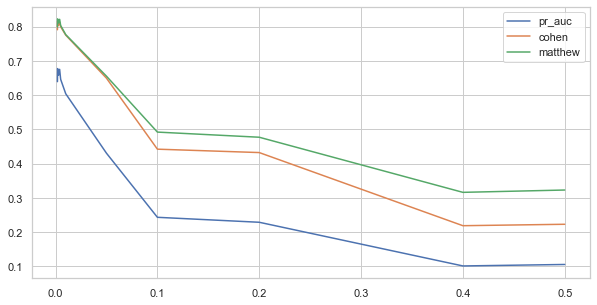

In [139]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ratios, pr_auc, label='pr_auc')
ax.plot(ratios, cohen, label='cohen')
ax.plot(ratios, matt, label='matthew')
ax.legend();

Пик качества при `ratio = 0.002`

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [140]:
from imblearn.under_sampling import NearMiss

In [141]:
pr_auc = []
cohen = []
matt = []
ratios = [0.00184, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5]

In [142]:
for ratio in tqdm(ratios):
    print(ratio)
    rus = NearMiss(sampling_strategy=ratio)
    X_train_rus, y_train_rus = rus.fit_resample(X_train.drop('Class', axis=1), X_train['Class'])
    cat7 = CatBoostClassifier(silent=True)
    cat7.fit(X_train_rus, y_train_rus)
    
    pr_auc_ = average_precision_score(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    pr_auc.append(pr_auc_)
    cohen_ = cohen_kappa_score(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    cohen.append(cohen_)
    matt_ = matthews_corrcoef(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    matt.append(matt_)
    
    print(pr_auc_)
    print(cohen_)
    print(matt_)
    print('_________')

0.00184
0.6562449596458945
0.7997942217552176
0.8096706420078524
_________
0.002
0.6271826089894064
0.7870023681914495
0.7915037854482287
_________
0.003
0.4275466349252869
0.6490980853470371
0.6531534135015236
_________
0.004
0.10130672099306526
0.23084125704174907
0.316184015232932
_________
0.005
0.030646616521636267
0.074634289533548
0.17099289436149898
_________
0.01
0.007945212964609165
0.016898418374965862
0.0808636802957435
_________
0.05
0.0018665745282919434
0.0014075376330809908
0.0239546711604364
_________
0.1
0.0019677397742526195
0.0015617390759210537
0.02662638441899513
_________
0.2
0.0017401572389052942
0.0010671740079160053
0.022396531817087968
_________
0.4
0.0014872846576661177
0.0005513221065023277
0.015787901901989306
_________
0.5
0.0014089046445314817
0.00039137429323354844
0.013093496149321949
_________



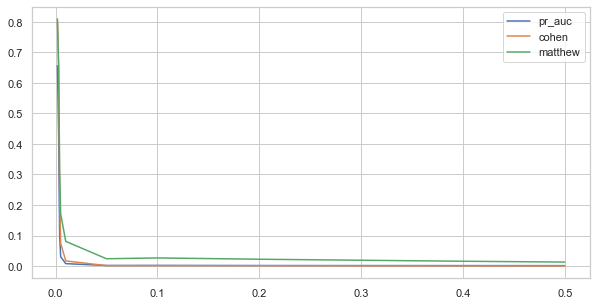

In [143]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ratios, pr_auc, label='pr_auc')
ax.plot(ratios, cohen, label='cohen')
ax.plot(ratios, matt, label='matthew')
ax.legend();

Пик при `ratio = 0.00184`. Зафиксирую это значение и переберу `n_neighbours`

In [144]:
pr_auc = []
cohen = []
matt = []
neighbours = range(3, 11)

In [146]:
for n in tqdm(neighbours):
    print(n)
    rus = NearMiss(sampling_strategy=0.00184, n_neighbors=n)
    X_train_rus, y_train_rus = rus.fit_resample(X_train.drop('Class', axis=1), X_train['Class'])
    cat7 = CatBoostClassifier(silent=True)
    cat7.fit(X_train_rus, y_train_rus)
    
    pr_auc_ = average_precision_score(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    pr_auc.append(pr_auc_)
    cohen_ = cohen_kappa_score(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    cohen.append(cohen_)
    matt_ = matthews_corrcoef(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
    matt.append(matt_)
    
    print(pr_auc_)
    print(cohen_)
    print(matt_)
    print('_________')

3
0.6562449596458945
0.7997942217552176
0.8096706420078524
_________
4
0.6754004168225988
0.8129917093370508
0.8214346011341345
_________
5
0.6585241840809816
0.8041405264648531
0.8110844637119163
_________
6
0.6585241840809816
0.8041405264648531
0.8110844637119163
_________
7
0.6394277687396348
0.7909907339649391
0.7992051463662754
_________
8
0.6754004168225988
0.8129917093370508
0.8214346011341345
_________
9
0.6394277687396348
0.7909907339649391
0.7992051463662754
_________
10
0.6585241840809816
0.8041405264648531
0.8110844637119163
_________



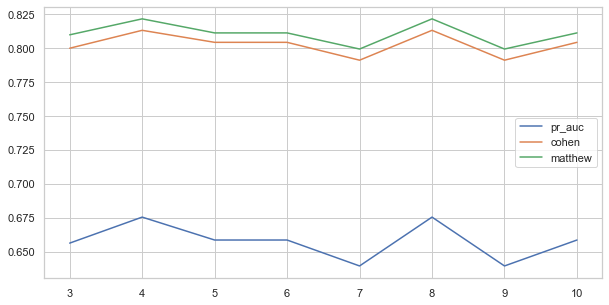

In [147]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(neighbours, pr_auc, label='pr_auc')
ax.plot(neighbours, cohen, label='cohen')
ax.plot(neighbours, matt, label='matthew')
ax.legend();

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

Я выбрал TomekLinks. При настройке `samplin_stratehy = 'all'` алгоритм находит близкие объекты разных классов и удаляет их.
<img src="https://imbalanced-learn.org/stable/_images/sphx_glr_plot_illustration_tomek_links_001.png" width="400"/>
<img src="https://imbalanced-learn.org/stable/_images/sphx_glr_plot_illustration_tomek_links_002.png" width="800"/>

In [148]:
from imblearn.under_sampling import TomekLinks

In [149]:
pr_auc = []
cohen = []
matt = []
ratios = [0.00184, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5]

In [150]:
rus = TomekLinks(sampling_strategy='all')
X_train_rus, y_train_rus = rus.fit_resample(X_train.drop('Class', axis=1), X_train['Class'])
cat7 = CatBoostClassifier(silent=True)
cat7.fit(X_train_rus, y_train_rus)

pr_auc_ = average_precision_score(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
pr_auc.append(pr_auc_)
cohen_ = cohen_kappa_score(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
cohen.append(cohen_)
matt_ = matthews_corrcoef(X_test['Class'], cat7.predict(X_test.drop('Class', axis=1)))
matt.append(matt_)

print(pr_auc_)
print(cohen_)
print(matt_)

0.6562449596458945
0.7997942217552176
0.8096706420078524


Очень круто сработало

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

Не смогу

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [35]:
from sklearn.preprocessing import StandardScaler

In [70]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    return 2 * harm(n - 1) - 2 * (n - 1) / (n + 0.000001)

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        depth: int - path length up to current node
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])
    if node.kind == 'external':
        return scores + c_factor(node.size) + depth
    else:
        w = node.w
        b = node.b
        right = X[(X - b) @ w > 0]
        left = X[(X - b) @ w <= 0]
        scores[(X - b) @ w > 0] = calc_height(right, depth+1, node.right)
        scores[(X - b) @ w <= 0] = calc_height(left, depth+1, node.left)
    return scores
    
#     if node.kind == 'internal':
#         node = node.left if (X * node.w).sum() >= node.b else node.right
#         height = calc_height(X, depth+1, node)
#     return node.depth + c_n

def harm(i):
    return np.log(i) + np.euler_gamma


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth
        """
        self.depth = 0
        self.max_depth = max_depth

        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        if depth + 1 > self.max_depth or X.shape[0] <= 1:
            kind = 'external'
            return Node(X, depth, None, None, kind, None, None)
        w = np.random.normal(size=X.shape[1])
        b = []
        for i in range(X.shape[1]):
            try:
                b.append(np.random.uniform(X[:, i].min(), X[:, i].max()))
            except:
                print(X[:, i])
                print(node)
        b = np.array(b)
        kind = 'internal'
        left_data = X[(X - b) @ w <= 0]
        right_data = X[(X - b) @ w > 0]
        left = self.grow(left_data, depth+1)
        right = self.grow(right_data, depth+1)
        return Node(X, depth, left, right, kind, w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        return calc_height(X, 0, self.root)
        
    

In [71]:
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        self.n_bst = int(X.shape[0] * self.subsample_rate)
        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(X)
        for i in range(self.n_trees):
            indices = np.random.choice(range(X.shape[0]), size=self.n_bst)
            self.trees.append(RandomizedTree(X[indices], self.max_depth))
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        scores = np.zeros(X.shape[0])
        for tree in self.trees:
            scores += tree.score_samples(X)
        scores = scores / self.n_trees
        return 2**(-scores / c_factor(self.n_bst))

    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scaler = StandardScaler()
        X = self.scaler.transform(X)
        scores = self.score_samples(X)
        labels = 1 * (scores > self.contamination)

        return labels, scores


In [77]:
eif = ExtendedIsolationForest(10, 0.2, 10, contamination=0.9)

In [78]:
eif.fit(X_train.drop('Class', axis=1))

ExtendedIsolationForest(n_trees=10, max_depth=10, subsample_rate=0.2, contamination=0.9, is_fit=False)

In [79]:
pred, scores = eif.predict(X_test.drop('Class', axis=1).values)

<ipython-input-70-1319494dea29>:40: RuntimeWarning: invalid value encountered in log
  return np.log(i) + np.euler_gamma
<ipython-input-70-1319494dea29>:40: RuntimeWarning: divide by zero encountered in log
  return np.log(i) + np.euler_gamma
<ipython-input-71-5397ceaf0ebc>:84: RuntimeWarning: invalid value encountered in greater
  labels = 1 * (scores > self.contamination)


In [80]:
pred.sum()

163

In [81]:
scores

array([0.36382889, 0.3658114 , 0.3678557 , ..., 0.38035712, 0.37746154,
       0.36382889])

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [82]:
from sklearn.ensemble import IsolationForest

In [83]:
isf = IsolationForest(100)
eif = ExtendedIsolationForest(100, 0.2, 10)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_estimators=100 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [84]:
isf.fit(X_train.drop('Class', axis=1))

IsolationForest()

In [85]:
eif.fit(X_train.drop('Class', axis=1))

ExtendedIsolationForest(n_trees=100, max_depth=10, subsample_rate=0.2, contamination=0.01, is_fit=False)

In [86]:
print(average_precision_score(X_test['Class'], isf.predict(X_test.drop('Class', axis=1))))
print(cohen_kappa_score(X_test['Class'], isf.predict(X_test.drop('Class', axis=1))))
print(matthews_corrcoef(X_test['Class'], isf.predict(X_test.drop('Class', axis=1))))

0.0009713525036013077
-0.0008206996697563973
-0.06143637523893004


In [89]:
pred = eif.predict(X_test.drop('Class', axis=1))
print(average_precision_score(X_test['Class'], pred))
print(cohen_kappa_score(X_test['Class'], pred))
print(matthews_corrcoef(X_test['Class'], pred))

<ipython-input-70-1319494dea29>:40: RuntimeWarning: invalid value encountered in log
  return np.log(i) + np.euler_gamma
<ipython-input-70-1319494dea29>:40: RuntimeWarning: divide by zero encountered in log
  return np.log(i) + np.euler_gamma
<ipython-input-71-5397ceaf0ebc>:84: RuntimeWarning: invalid value encountered in greater
  labels = 1 * (scores > self.contamination)


ValueError: Found input variables with inconsistent numbers of samples: [42722, 2]

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [ ]:
#your code here

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [ ]:
#your code here

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [ ]:
#your code here

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. Если вы получите ровно 0, то мы посчитаем вас невероятно везучим человеком и в качестве поощрения зачтем теорминимум на коллоквиуме. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [234]:
import numpy as np

np.random.randn()

-0.6367161191846675